In [7]:
#%% Imports
from utils import *
import numpy as np
import sklearn.mixture
import seaborn as sbn
import ProteinDataPreparation
import ProteinGaussianClustering
import ProteinFucciPseudotime
plt.rcParams['pdf.fonttype'], plt.rcParams['ps.fonttype'], plt.rcParams['savefig.dpi'] = 42, 42, 300 #Make PDF text readable


In [2]:
#%% Read in the protein data (methods in ProteinDataPreparation.py)
my_df = ProteinDataPreparation.read_raw_data()
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


reading raw protein IF data
loaded raw data


637104: number of cells before filtering empty wells
636296: number of cells after filtering empty wells
filtering out of focus
636296: number of cells before filtering out of focus images
629997: number of cells after filtering out of focus images
finished filtering
filtering negative staining
629997: number of cells before filtering negative staining from first batch
590511: number of cells after filtering negative staining from first batch
finished filtering
filtering bad fields of view (negative staining, unspecific, etc)
590511: number of cells before filtering out of focus images
521702: number of cells after filtering out of focus images
finished filtering
filtering failed antibodies
521702: number of cells before filtering antibodies failed in HPAv19
505930: number of cells after filtering antibodies failed in HPAv19
finished filtering
filtering mitotic proteins
505930: number of cells before filtering mitotic/microtubule proteins
505335: number of cells after filtering mitotic

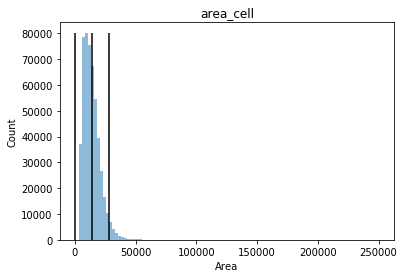

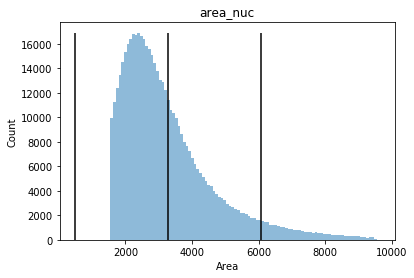

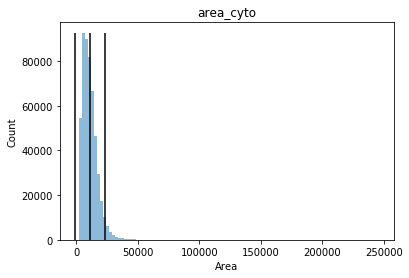

filtering super big nuclei
505335: number of cells before filtering out super big nuclei
477855: number of cells after filtering out super big nuclei
finished filtering on nuclei


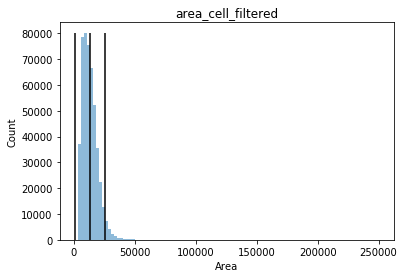

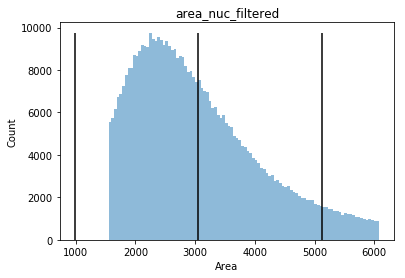

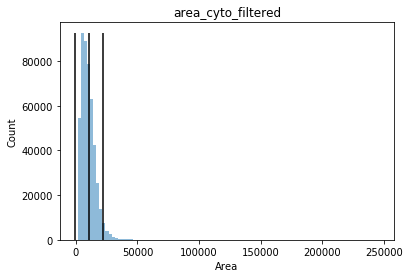

filtering low cell counts
477855: number of cells before filtering out samples with < 60 cells
477118: number of cells after filtering out samples with < 60 cells
finished filtering on cell count


In [3]:
#%% Idea: Filter the raw data (methods in ProteinDataPreparation.py)
# Execution: Use manual annotations and nucleus size to filter samples and images
# Output: Filtered dataframe
my_df_filtered = ProteinDataPreparation.apply_manual_filtering(my_df, result_dict, ab_dict)
my_df_filtered = ProteinDataPreparation.apply_big_nucleus_filter(my_df_filtered)
my_df_filtered = ProteinDataPreparation.apply_cell_count_filter(my_df_filtered)
my_df_filtered.to_csv("input/processed/python/nuc_predicted_prob_phases_filtered.csv")

plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


In [4]:
#%% Idea: Filter for variation and get compartments (methods in ProteinDataPreparation.py)
# Execution: Use annotated variation and compartment information
# Output: Number of cells filtered
my_df_filtered_variation, my_df_filtered_novariation = ProteinDataPreparation.apply_variation_filter(my_df_filtered, result_dict, my_df)

## Uncomment to output these dataframes (used for skewness / kurtosis analysis)
# my_df_filtered_variation.to_csv("output/nuc_predicted_prob_phases_filtered_variation.csv")
# my_df_filtered_novariation.to_csv("output/nuc_predicted_prob_phases_filtered_novariation.csv")

# filter out the ones missing compartment information; these are localized to mitotic structures and handled differently
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered_variation)
wp_iscell, wp_isnuc, wp_iscyto, my_df_filtered_compartmentvariation = ProteinDataPreparation.metacompartments(u_well_plates, compartment_dict, my_df_filtered_variation)

# demonstrate that there are no more missing compartment information
plate, u_plate, well_plate, well_plate_imgnb, u_well_plates, ab_objnum, area_cell, area_nuc, area_cyto, ensg_dict, ab_dict, result_dict, compartment_dict, ENSG, antibody, result, compartment = ProteinDataPreparation.read_sample_info(my_df_filtered_compartmentvariation)
wp_iscell, wp_isnuc, wp_iscyto, my_df_filtered_compartmentvariation = ProteinDataPreparation.metacompartments(u_well_plates, compartment_dict, my_df_filtered_compartmentvariation)
wp_ensg, wp_ab, wp_prev_ccd, wp_prev_notccd, wp_prev_negative, prev_ccd_ensg, prev_notccd_ensg, prev_negative_ensg = ProteinDataPreparation.previous_results(u_well_plates, result_dict, ensg_dict, ab_dict)


637104: number of cells before filtering for variation
276856: number of cells in samples with variation
200262: number of cells in samples without variation
14: samples without compartment information; to be filtered since they're biologically defined as CCD and not included in the analysis
276856: number of cells before filtering for compartment information
273709: number of cells before filtering for compartment information
0: samples without compartment information; to be filtered since they're biologically defined as CCD and not included in the analysis
273709: number of cells before filtering for compartment information
273709: number of cells before filtering for compartment information


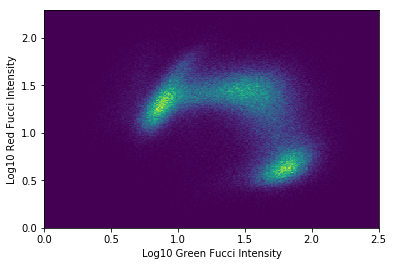

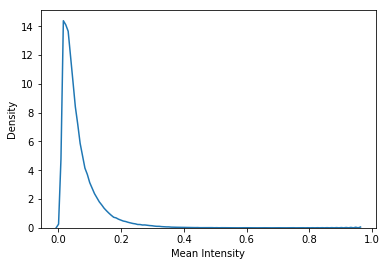

In [5]:
#%% Idea: Get and process intensities (methods in ProteinDataPreparation.py and ProteinGaussianClustering.py)
# Execution: get intensities; zero center fucci intensities
# Output: Fucci plot
ab_nuc, ab_cyto, ab_cell, mt_cell, green_fucci, red_fucci = ProteinDataPreparation.read_sample_data(my_df_filtered_compartmentvariation)
log_green_fucci, log_red_fucci, log_green_fucci_zeroc, log_red_fucci_zeroc, log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale, fucci_data = ProteinGaussianClustering.zero_center_fucci(green_fucci, red_fucci, u_plate, well_plate, plate)
    
plt.hist2d(log_green_fucci_zeroc_rescale,log_red_fucci_zeroc_rescale,bins=200)
plt.xlabel("Log10 Green Fucci Intensity")
plt.ylabel("Log10 Red Fucci Intensity")
plt.savefig("figures/FucciPlotProteinIFData_unfiltered.png")
plt.show()
plt.close()

# General picture of antibody intensity density
sbn.distplot(ab_cell, hist=False)
plt.xlabel("Mean Intensity")
plt.ylabel("Density")
plt.savefig("figures/antibody_cell_intensity.pdf")
plt.show()
plt.close()

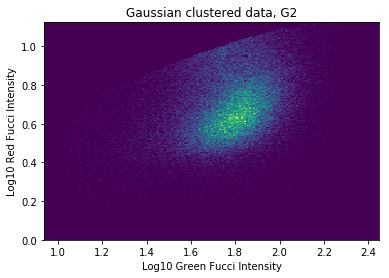

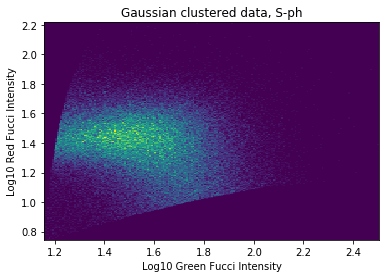

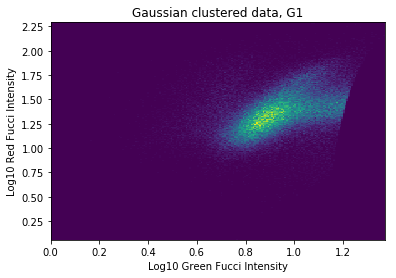

1253: number of genes tested
491: number of passing genes at 5.0% FDR in compartment
469: number of passing genes at 5.0% FDR in compartment (no replicate)
5: number of CCD genes shown to be CCD in both replicates
12: number of CCD genes shown to be CCD in just one replicate
17: number of CCD genes shown to be non-CCD in both replicate
469: number of passing antibodies at 5.0% FDR in compartment (no replicate)
5: number of duplicated antibodies shown to be CCD in both replicates
12: number of duplicated antibodies shown to be CCD in just one replicate
17: number of duplicated antibodies shown to be non-CCD in both replicate


In [8]:
#%% Idea: Gaussian clustering per plate to identify G1/S/G2 and do kruskal test for variance
# Exec: sklearn.mixture.GaussianMixture & scipy.stats.kruskal
# Output: FDR for cell cycle variation per well per compartment
cluster_labels = ProteinGaussianClustering.gaussian_clustering(log_green_fucci_zeroc_rescale, log_red_fucci_zeroc_rescale)

# NB! The cluster labels can change if any prior analysis changes. 
# Inspect the plots so that top-left FUCCI cluster is G1, top-right is S, bottom-right is G2.
g1, sph, g2 = cluster_labels == 2, cluster_labels == 1, cluster_labels == 0
alpha_gauss, doGenerateBoxplotsPerGene = 0.05, True
wp_comp_kruskal_gaussccd_adj, wp_pass_kruskal_gaussccd_bh_comp, wp_mt_kruskal_gaussccd_adj, wp_pass_gaussccd_bh_mt =  ProteinGaussianClustering.gaussian_clustering_analysis(alpha_gauss, doGenerateBoxplotsPerGene, g1, sph, g2, wp_ensg, well_plate, u_well_plates, ab_cell, ab_nuc, ab_cyto, mt_cell, wp_iscell, wp_isnuc, wp_iscyto)

# General look at replicates in mock-bulk analysis
ProteinGaussianClustering.address_replicates(alpha_gauss, wp_pass_kruskal_gaussccd_bh_comp, wp_ensg, wp_ab, u_well_plates)


[1.41692701 1.19758427]
[1.41692704 1.19758427]
[1.41692701 1.19758429]
[1.35131348 1.0463106 ]
[1.3513135 1.0463106]
[1.35131348 1.04631062]
[1.31856855 0.99282078]
[1.31856857 0.99282078]
[1.31856855 0.9928208 ]
[1.30931572 0.97916186]
[1.30931574 0.97916186]
[1.30931572 0.97916188]
[1.30722    0.97617003]
[1.30722002 0.97617003]
[1.30722    0.97617004]
[1.30678002 0.97554874]
[1.30678004 0.97554874]
[1.30678002 0.97554876]
[1.30668871 0.97542102]
[1.30668873 0.97542102]
[1.30668871 0.97542103]
[1.30666983 0.97539475]
[1.30666985 0.97539475]
[1.30666983 0.97539477]
[1.30666593 0.97538935]
[1.30666595 0.97538935]
[1.30666593 0.97538937]


C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


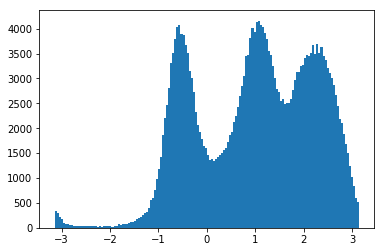

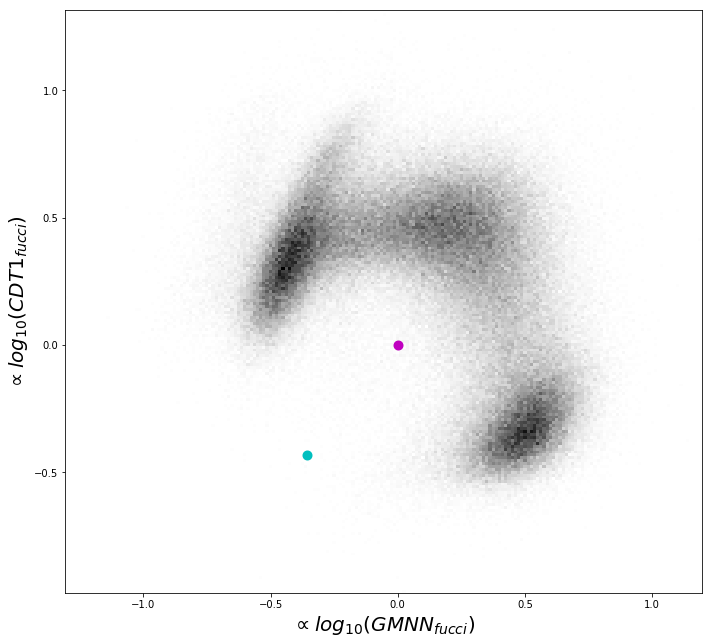

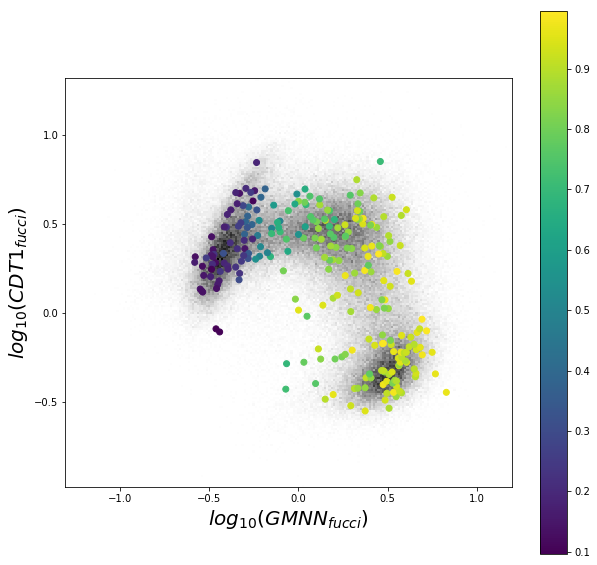

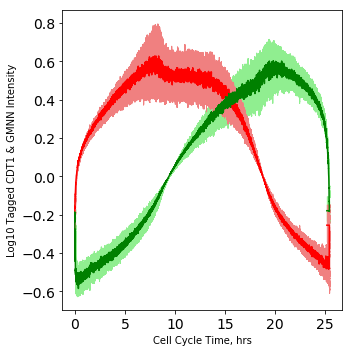

In [9]:
# Idea: Calculate polar coordinates based on FUCCI intensities
# Exec: Custom code in ProteinFucciPseudotime.py
# Output: GMNN antibody agreement with FUCCI pseudotime; FUCCI intensities overlayed on pseudotime
ProteinFucciPseudotime.fucci_polar_coordinate_calculations(fucci_data, 
                           ab_nuc,ab_cyto,ab_cell,mt_cell,area_cell, area_nuc,
                           well_plate,well_plate_imgnb, 
                           log_red_fucci_zeroc_rescale,log_green_fucci_zeroc_rescale)